In [106]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1959551599 seed_offset=0 real_seed=1959551599
core.init.random: RandomGenerator

In [107]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *

In [108]:
def within_360(ang):
    
    return ang - 360.0*int(ang/360.0)

In [109]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [110]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})
        
        if seq2 and ii == (n_residues/2) - 1:
            
            continue
        
        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [111]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'dfpmin', 1e-5, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [141]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64)
        pose.set_torsion(dof_dict[6*ii+1], 176)
        pose.set_torsion(dof_dict[6*ii+2], 53)
        pose.set_torsion(dof_dict[6*ii+3], -150)
        pose.set_torsion(dof_dict[6*ii+4], -71)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79)
    
    return pose

In [208]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        for key, val in enumerate(dofs_new):

            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    
    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        for key, val in dof_dict.iteritems():
            
            temp.set_torsion(val, dofs[key] - 60.0*inc/float(max_inc)*mode[key])

        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180
    return result

In [283]:
seq1 = 'agc'
seq2 = 'gcu'

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)
pmm = PyMOLMover()
pmm.apply(pose)
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires')

In [284]:
#pose.assign(find_minimum(pose, scorefxn, movemap))
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'linmin_iterated', 1e-5, True)
minmover.max_iter(100000)

In [290]:
import itertools

minimum = Pose()

#pose.assign(helix_state(pose, dof_dict))
pmm.apply(pose)
print pose.alpha(2)
minmover.apply(pose)
minimum.assign(pose)
h = 0.5
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(4/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-2, 2+h, h)
    
for pair in list(itertools.combinations(range(len(dofs)), 2)):
    
    x = tor_ranges[:, pair[0]]
    y = tor_ranges[:, pair[1]]

    for ii, xx in enumerate(x):
        
        if ii in range(6*(len(seq1)-1), 6*len(seq1)) and seq2:
        
            continue
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
       
            if jj in range(6*len(seq1)-1, 6*len(seq1)) and seq2:
        
                continue
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[pair[1]])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[pair[0]])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[pair[0], pair[0]] == 0:
        
        hessian[pair[0], pair[0]] = d2E_dx2[ind, ind]
        
    if hessian[pair[1], pair[1]] == 0:
        
        hessian[pair[1], [pair[1]]] = d2E_dy2[ind, ind]
        
    hessian[pair[0],pair[1]] = d2E_dxdy[ind, ind]
    hessian[pair[1],pair[0]] = d2E_dxdy[ind, ind]
    
               
               

pose.assign(minimum)

-65.3757536379


In [291]:
import scipy
import scipy.linalg
w,v = scipy.linalg.eigh(hessian)

In [292]:
print w 

print v[:,5]


[ -2.36394095e+02  -1.18179378e+02  -4.64413363e+01  -9.17694420e+00
  -2.35133047e+00  -1.09151170e-14  -4.92417959e-15  -3.99127044e-16
   3.81818493e-16   8.04774742e-15   1.82122125e+00   3.01049974e+00
   5.60680565e+00   2.01814585e+01   2.98396736e+01   3.63752063e+01
   5.16891602e+01   8.49846144e+01   1.36441392e+02   1.65774875e+02
   2.39982327e+02   2.82301810e+02   3.68309349e+02   5.78573175e+02
   9.46038634e+02   1.24375681e+03   2.49254337e+03   2.77486521e+03
   8.77524973e+03   1.26868031e+04   2.45698994e+04]
[  0.00000000e+00   2.68895484e-19   1.13801431e-16  -2.51375503e-16
   2.90985529e-16  -1.23574304e-16  -8.56676215e-16   6.50477746e-16
   4.32673385e-16  -6.86874428e-16   5.45807828e-16  -2.01377653e-16
  -4.62642384e-01  -3.97258496e-02   3.71415668e-01  -3.43490261e-01
   7.26944787e-01   3.02883398e-17   1.36274603e-15  -5.05010237e-16
  -8.12783188e-16   4.08235342e-16  -2.54625790e-16  -5.86720356e-16
   2.23381240e-16  -6.85267348e-17  -9.92961886e-1

143.123124399
171.398277396
262.261044072
336.620660085
472.864221688
818.870019587
1236.99836692
2192.4816955
2458.43773395
7934.30018732
12163.9104704
21682.6117152


IndexError: index 31 is out of bounds for axis 0 with size 31

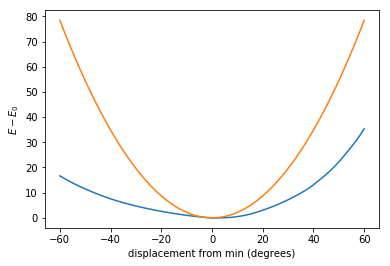

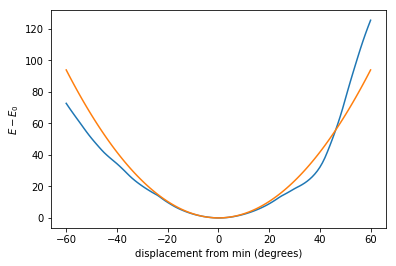

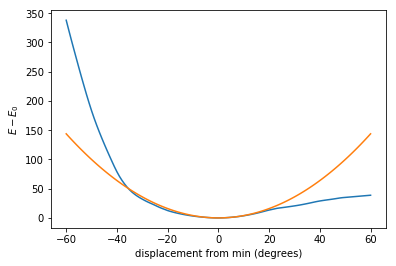

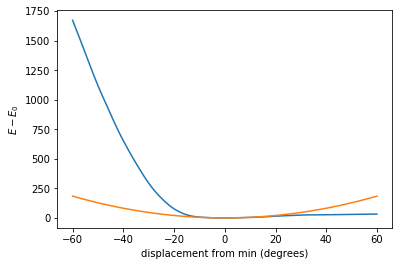

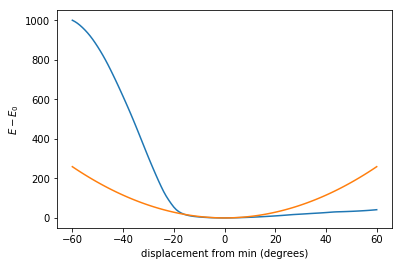

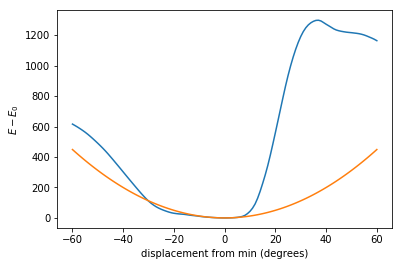

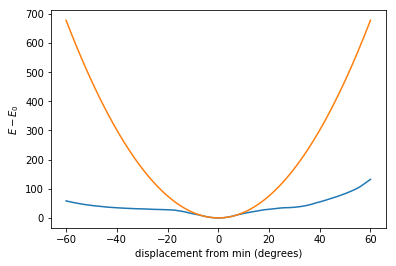

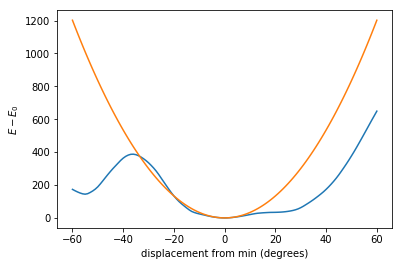

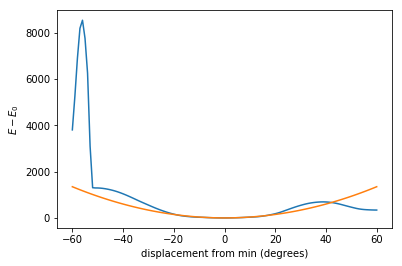

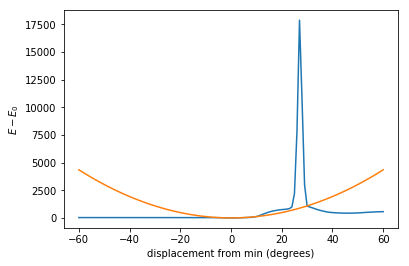

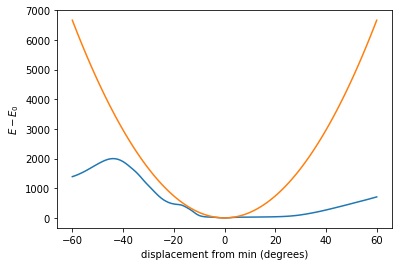

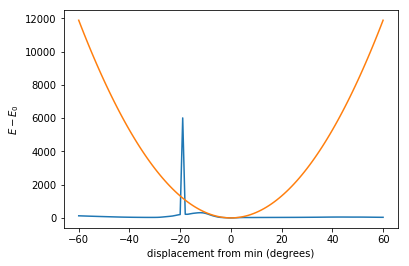

In [288]:
pose.assign(minimum)
kT = 1.0

for kk in range(19,39):

        
    K = w[kk]
    if K < 1: continue 
    mode = v[:,kk]
    observer = AddPyMOLObserver(pose, True)
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180
    #h = np.concatenate((np.append(h, 15), h[: :-1]))

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)
        #print E_0, scorefxn(pose)

    np.array(bar) 
    pose.assign(minimum)
    plt.figure()
    plt.plot(h, np.array(bar))
    print K
    plt.plot(h, 0.5*K*h_plot**2/kT)
    plt.xlabel('displacement from min (degrees)')
    plt.ylabel('$E-E_0$')
    

In [ ]:
from scipy.special import *
kT = 1
pose.assign(minimum)
Z_harm = 1
Z_scan = 1
for ii, K in enumerate(w):

    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 0.5)
    
    #if K < 1: continue
    
    sig = min(2*np.pi/3, 6*np.sqrt(kT/K))
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    pose.assign(minimum)
    print Z_i, Z_j

In [289]:
print -kT*np.log(Z_harm), -kT*np.log(Z_scan)

nan -8.87162149805
